In [52]:
#  búsqueda de valores faltantes, valores atípicos/extremos u outliers y registros duplicados.
import pandas as pd
import numpy as np
import openpyxl
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

Para manipular el archivo Excel usando Python instalamos la dependencia e importamos la biblioteca arriba

In [53]:
pip install openpyxl 

Note: you may need to restart the kernel to use updated packages.


In [54]:
# Leer todas las hojas del archivo Excel
internet_dataset = "Datasets\Internet.xlsx"
internet_file = pd.ExcelFile(internet_dataset)

<>:2: SyntaxWarning: invalid escape sequence '\I'
<>:2: SyntaxWarning: invalid escape sequence '\I'
C:\Users\Usuario\AppData\Local\Temp\ipykernel_9724\2447630919.py:2: SyntaxWarning: invalid escape sequence '\I'
  internet_dataset = "Datasets\Internet.xlsx"


Se usa el metodo head() de pandas para poder visualizar las columnas, con el fin de tener una noción a nivel general sobre su composición y estadísticas.

In [55]:
# Recorrer todas las hojas para obtener un resumen descriptivo
for hoja in internet_file.sheet_names:
    print(f"\n--- Resumen de la hoja: {hoja} ---")
    df = pd.read_excel(internet_file, sheet_name=hoja)
    
    # Información general
    print("Información del DataFrame:")
    print(df.info())
    
    # Resumen estadístico
    print("\nResumen estadístico:")
    print(df.describe(include='all'))

    # Revisar valores nulos
    print("\nValores nulos por columna:")
    print(df.isnull().sum())
    
    # Revisar los primeros 5 datos para tener una idea de la estructura
    print("\nPrimeras 5 filas:")
    print(df.head())


--- Resumen de la hoja: Acc_vel_loc_sinrangos ---
Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3065 entries, 0 to 3064
Columns: 125 entries, Provincia to 10000 Mbps
dtypes: float64(121), object(4)
memory usage: 2.9+ MB
None

Resumen estadístico:
           Provincia    Partido Localidad Link Indec         Otros  \
count           3065       3065      3065       3065   1030.000000   
unique            24        432      2778       2664           NaN   
top     BUENOS AIRES  San Justo     Otros  Sin Datos           NaN   
freq             717         56        70         74           NaN   
mean             NaN        NaN       NaN        NaN    318.614563   
std              NaN        NaN       NaN        NaN   2964.939611   
min              NaN        NaN       NaN        NaN    -15.000000   
25%              NaN        NaN       NaN        NaN      1.000000   
50%              NaN        NaN       NaN        NaN      6.000000   
75%              NaN 

### Análisis de la hoja 'Acc_vel_loc_sinrangos' 
Proporciona datos detallados de accesos a internet por diferentes velocidades de conexión en varias localidades de Argentina.  Los nulos en ' Acc_vel_loc_sinrangos ' podrían representar usuarios no suscriptos. Vamos a reemplazarlos por 0 para no perder ningun valor. 

In [56]:
# Cargar la hoja Acc_vel_loc_sinrangos
hoja_acc_vel = pd.read_excel(internet_file, sheet_name='Acc_vel_loc_sinrangos')

# Reemplazar nulos por 0 en todas las columnas
hoja_acc_vel.fillna(0, inplace=True)

Como había mbps de hasta 68405 y el máximo de mbps es 1000, se indujo que fueron errores de data entry y se los cambió a 1000 por ser el máximo

In [101]:
# Establecer un umbral máximo de 1000 Mbps y reemplazar valores fuera de rango
velocidad_columnas = [col for col in hoja_acc_vel.columns if 'Mbps' in col]
for col in velocidad_columnas:
    hoja_acc_vel[col] = np.where(hoja_acc_vel[col] > 1000, 1000, hoja_acc_vel[col])

# Revisar los primeros 5 registros para verificar cómo quedó la limpieza
print("\nPrimeras 5 filas después de la limpieza:")
print(hoja_acc_vel.head())


Primeras 5 filas después de la limpieza:
      Provincia     Partido          Localidad Link Indec  Otros  0,256 Mbps  \
0  BUENOS AIRES  25 de Mayo         25 de Mayo    6854100    0.0         0.0   
1  BUENOS AIRES  25 de Mayo    Agustín Mosconi    6854010    0.0         0.0   
2  BUENOS AIRES  25 de Mayo          Del Valle    6854020    0.0         0.0   
3  BUENOS AIRES  25 de Mayo          Ernestina    6854030    0.0         0.0   
4  BUENOS AIRES  25 de Mayo  Gobernador Ugarte    6854040    0.0         0.0   

   0,5 Mbps  0,512 Mbps  0,75 Mbps  1 Mbps  ...  680 Mbps  700 Mbps  800 Mbps  \
0       2.0         0.0       19.0     0.0  ...       0.0       0.0       0.0   
1       0.0         0.0        0.0     0.0  ...       0.0       0.0       0.0   
2       1.0         0.0        0.0     0.0  ...       0.0       0.0       0.0   
3       0.0         0.0        0.0     0.0  ...       0.0       0.0       0.0   
4       0.0         0.0        0.0     0.0  ...       0.0       0.0     

In [59]:
# Calcular el porcentaje de valores nulos y ceros por columna
nulos_por_columna = hoja_acc_vel.isnull().sum() / len(hoja_acc_vel) * 100
ceros_por_columna = (hoja_acc_vel == 0).sum() / len(hoja_acc_vel) * 100

# Mostrar las columnas con más del 80% de valores nulos o ceros
print("Columnas con más del 80% de valores nulos:")
print(nulos_por_columna[nulos_por_columna > 80])

print("\nColumnas con más del 80% de valores ceros:")
print(ceros_por_columna[ceros_por_columna > 80])

Columnas con más del 80% de valores nulos:
Series([], dtype: float64)

Columnas con más del 80% de valores ceros:
0,256 Mbps    98.825449
0,512 Mbps    82.871126
0,75 Mbps     90.734095
1,5 Mbps      99.510604
2,2 Mbps      99.967374
                ...    
999 Mbps      99.445351
1000 Mbps     86.296900
1024 Mbps     99.934747
4000 Mbps     99.967374
10000 Mbps    99.934747
Length: 107, dtype: float64


Los datos agregados por provincia, partido y localidad permiten crear gráficos que muestren la distribución del servicio de internet en todo el país, destacando dónde hay más y menos cobertura.

In [60]:
# Seleccionar las columnas numéricas (evitando las columnas de texto como Provincia, Partido, Localidad, etc.)
columnas_velocidad = hoja_acc_vel.columns[5:]  # Asumiendo que las primeras 5 columnas son texto

# Agrupar por provincia y sumar las columnas de velocidades
suscriptores_por_provincia = hoja_acc_vel.groupby('Provincia')[columnas_velocidad].sum()

# Mostrar el resultado
suscriptores_por_provincia.head()

,"0,256 Mbps","0,5 Mbps","0,512 Mbps","0,75 Mbps",1 Mbps,"1,5 Mbps",2 Mbps,"2,2 Mbps","2,5 Mbps",3 Mbps,...,680 Mbps,700 Mbps,800 Mbps,850 Mbps,900 Mbps,999 Mbps,1000 Mbps,1024 Mbps,4000 Mbps,10000 Mbps
Provincia,,,,,,,,,,,,,,,,,,,,,
BUENOS AIRES,18.0,1847.0,169.0,4611.0,16579.0,141.0,18363.0,0.0,21.0,36880.0,...,0.0,0.0,563.0,0.0,0.0,26.0,112203.0,0.0,0.0,0.0
CABA,31.0,451.0,34.0,1000.0,1000.0,0.0,249.0,0.0,0.0,1000.0,...,0.0,1.0,1.0,0.0,0.0,25.0,1000.0,0.0,0.0,0.0
CATAMARCA,0.0,34.0,37.0,0.0,176.0,0.0,115.0,0.0,0.0,1644.0,...,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0
CHACO,0.0,234.0,2.0,0.0,416.0,0.0,780.0,0.0,0.0,2925.0,...,0.0,0.0,0.0,0.0,0.0,0.0,150.0,0.0,0.0,0.0
CHUBUT,8.0,69.0,34.0,836.0,247.0,0.0,1870.0,0.0,0.0,4507.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0


In [61]:
# Agrupar por Provincia, Partido y Localidad, y sumar las columnas de velocidades
suscriptores_por_localidad = hoja_acc_vel.groupby(['Provincia', 'Partido', 'Localidad'])[columnas_velocidad].sum().reset_index()

# Mostrar las primeras filas del resultado
suscriptores_por_localidad.head()

,Provincia,Partido,Localidad,"0,256 Mbps","0,5 Mbps","0,512 Mbps","0,75 Mbps",1 Mbps,"1,5 Mbps",2 Mbps,...,680 Mbps,700 Mbps,800 Mbps,850 Mbps,900 Mbps,999 Mbps,1000 Mbps,1024 Mbps,4000 Mbps,10000 Mbps
0,BUENOS AIRES,25 de Mayo,25 de Mayo,0.0,2.0,0.0,19.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,BUENOS AIRES,25 de Mayo,Agustín Mosconi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,BUENOS AIRES,25 de Mayo,Del Valle,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,BUENOS AIRES,25 de Mayo,Ernestina,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,BUENOS AIRES,25 de Mayo,Gobernador Ugarte,0.0,0.0,0.0,0.0,0.0,0.0,106.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
# Agrupar por Provincia y Partido, y sumar las columnas de velocidades
suscriptores_por_partido = hoja_acc_vel.groupby(['Provincia', 'Partido'])[columnas_velocidad].sum().reset_index()
suscriptores_por_partido.head()

,Provincia,Partido,"0,256 Mbps","0,5 Mbps","0,512 Mbps","0,75 Mbps",1 Mbps,"1,5 Mbps",2 Mbps,"2,2 Mbps",...,680 Mbps,700 Mbps,800 Mbps,850 Mbps,900 Mbps,999 Mbps,1000 Mbps,1024 Mbps,4000 Mbps,10000 Mbps
0,BUENOS AIRES,25 de Mayo,0.0,3.0,0.0,19.0,0.0,0.0,280.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,BUENOS AIRES,9 de Julio,0.0,0.0,0.0,9.0,9.0,0.0,193.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0
2,BUENOS AIRES,AMBA,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,BUENOS AIRES,Adolfo Alsina,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,BUENOS AIRES,Adolfo Gonzales Chaves,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


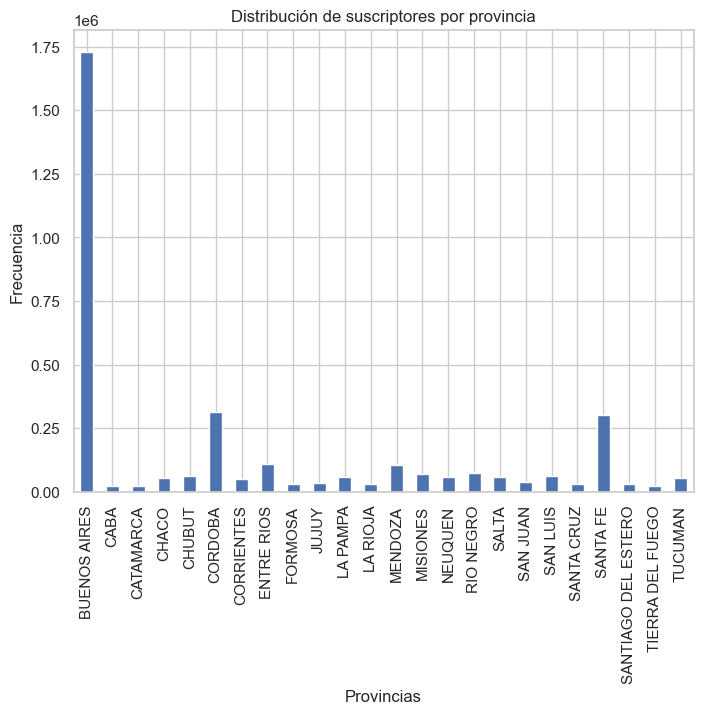

Análisis de la distribución de suscriptores por provincia:
-----------------------------------------------------------
Provincias con mayor número de suscriptores:
Provincia
BUENOS AIRES    1730406.0
CORDOBA          313345.0
SANTA FE         300902.0
dtype: float64

Provincias con menor número de suscriptores:
Provincia
CATAMARCA           20903.0
TIERRA DEL FUEGO    21162.0
CABA                24030.0
dtype: float64


In [104]:
# Generar el gráfico de distribución de suscriptores por provincia
suscriptores_por_provincia_total = suscriptores_por_provincia.sum(axis=1)

# Gráfico
plt.figure(figsize=(8, 6))
suscriptores_por_provincia_total.plot(kind='bar')
plt.title("Distribución de suscriptores por provincia")
plt.xlabel("Provincias")
plt.ylabel("Frecuencia")
plt.show()

# Análisis impreso
print("Análisis de la distribución de suscriptores por provincia:")
print("-----------------------------------------------------------")
print(f"Provincias con mayor número de suscriptores:\n{suscriptores_por_provincia_total.nlargest(3)}")
print(f"\nProvincias con menor número de suscriptores:\n{suscriptores_por_provincia_total.nsmallest(3)}")


Las provincias con mayores suscriptores tienden a ser áreas urbanas grandes, mientras que las provincias con menos suscriptores probablemente sean áreas rurales.

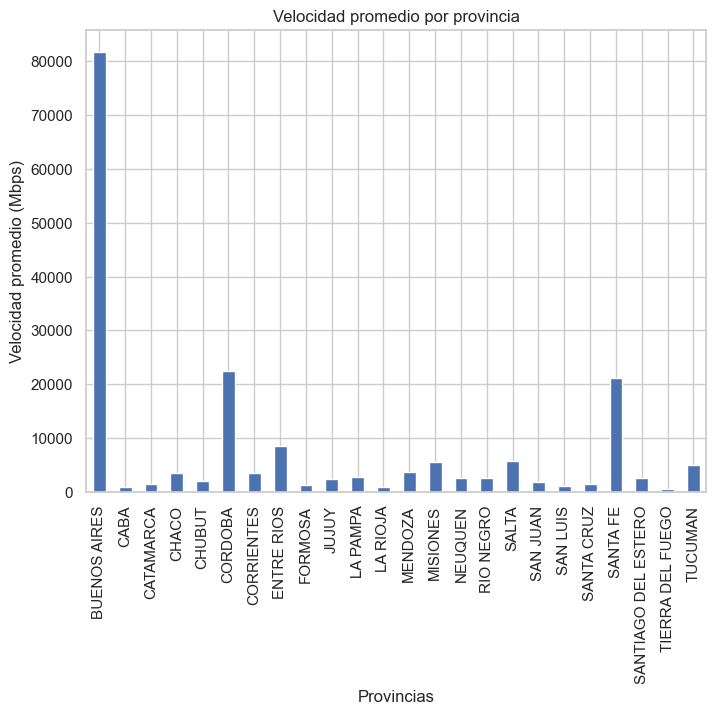

Análisis de la velocidad promedio por provincia:
-------------------------------------------------
Provincias con mayor velocidad promedio:
Provincia
BUENOS AIRES    81795.75
CORDOBA         22434.75
SANTA FE        21104.50
dtype: float64

Provincias con menor velocidad promedio:
Provincia
TIERRA DEL FUEGO    542.00
CABA                862.75
LA RIOJA            961.75
dtype: float64


In [106]:
# Seleccionar algunas columnas de velocidades para análisis
velocidades = ['0,5 Mbps', '1 Mbps', '10 Mbps', '100 Mbps']
# Calcular la velocidad promedio por provincia
promedio_velocidad_provincia = suscriptores_por_provincia[velocidades].mean(axis=1)

# Gráfico
promedio_velocidad_provincia.plot(kind='bar', figsize=(8, 6))
plt.title("Velocidad promedio por provincia")
plt.xlabel("Provincias")
plt.ylabel("Velocidad promedio (Mbps)")
plt.show()

# Análisis impreso
print("Análisis de la velocidad promedio por provincia:")
print("-------------------------------------------------")
print(f"Provincias con mayor velocidad promedio:\n{promedio_velocidad_provincia.nlargest(3)}")
print(f"\nProvincias con menor velocidad promedio:\n{promedio_velocidad_provincia.nsmallest(3)}")

In [65]:
# Detección de outliers basados en el z-score para provincias
z_scores = stats.zscore(suscriptores_por_provincia_total)
outliers = suscriptores_por_provincia_total[z_scores > 3]

# Análisis impreso
print("Detección de outliers en el número de suscriptores por provincia:")
print("-------------------------------------------------------------------")
if not outliers.empty:
    print(f"Provincias con un número de suscriptores significativamente superior al promedio (outliers):\n{outliers}")
else:
    print("No se han detectado outliers en el número de suscriptores por provincia.")

Detección de outliers en el número de suscriptores por provincia:
-------------------------------------------------------------------
Provincias con un número de suscriptores significativamente superior al promedio (outliers):
Provincia
BUENOS AIRES    1730406.0
dtype: float64


In [66]:
# Detección de outliers por debajo del promedio (valores muy bajos)
z_scores_neg = stats.zscore(suscriptores_por_provincia_total)
outliers_bajos = suscriptores_por_provincia_total[z_scores_neg < -3]

# Análisis impreso
print("Detección de outliers bajos en el número de suscriptores por provincia:")
print("-----------------------------------------------------------------------")
if not outliers_bajos.empty:
    print(f"Provincias con un número de suscriptores significativamente inferior al promedio (outliers bajos):\n{outliers_bajos}")
else:
    print("No se han detectado outliers bajos en el número de suscriptores por provincia.")

Detección de outliers bajos en el número de suscriptores por provincia:
-----------------------------------------------------------------------
No se han detectado outliers bajos en el número de suscriptores por provincia.


### Análisis de la hoja 'Velocidad_sin_Rangos'
Muestra estadísticas de acceso a internet desglosadas por velocidad y provincia.

In [67]:
# Cargar la hoja Acc_vel_loc_sinrangos
hoja_velocidad_sin_rangos = pd.read_excel(internet_file, sheet_name='Velocidad_sin_Rangos')
hoja_velocidad_sin_rangos

,Año,Trimestre,Provincia,Otros,"0,256 Mbps","0,375 Mbps","0,625 Mbps","0,5 Mbps","0,512 Mbps","0,75 Mbps",...,2048 Mbps,2529 Mbps,3072 Mbps,4000 Mbps,5000 Mbps,5125 Mbps,6000 Mbps,7000 Mbps,8000 Mbps,10000 Mbps
0,2024.0,1.0,Buenos Aires,125147.0,18.0,0.0,0.0,25815.0,169.0,4611.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2024.0,1.0,Capital Federal,0.0,31.0,0.0,0.0,451.0,34.0,1307.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2024.0,1.0,Catamarca,70.0,0.0,0.0,0.0,34.0,37.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2024.0,1.0,Chaco,3816.0,0.0,0.0,0.0,234.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2024.0,1.0,Chubut,16640.0,8.0,0.0,0.0,69.0,34.0,836.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620,2017.0,4.0,Santa Fe,14119.0,0.0,0.0,0.0,3109.0,0.0,7637.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
621,2017.0,4.0,Santiago Del Estero,0.0,0.0,0.0,0.0,41.0,0.0,909.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
622,2017.0,4.0,Tierra Del Fuego,0.0,0.0,0.0,0.0,6.0,0.0,282.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
623,2017.0,4.0,Tucumán,0.0,0.0,0.0,0.0,105.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Limpiamos los datos para asegurarnos que los datos estém listos para el análisis.

In [68]:
# Eliminar filas con valores nulos en las columnas clave
hoja_velocidad_sin_rangos = hoja_velocidad_sin_rangos.dropna(subset=['Año', 'Trimestre', 'Provincia'])

Vamos a agrupar por trimestre y año para sumar la cantidad de suscriptores por velocidad de internet.
- El análisis trimestral nos permite observar si las velocidades más altas están ganando terreno frente a las más bajas y si la infraestructura de internet en general está mejorando.
- Al agrupar los datos por provincia, podemos identificar si algunas regiones tienen mejor acceso a velocidades más rápidas en comparación con otras.
- El análisis anual nos ayuda a ver si las velocidades más rápidas (como 1000 Mbps o más) están siendo adoptadas gradualmente a lo largo de los años.

In [69]:
# Agrupar por Año y Trimestre y sumar las velocidades
agrupacion_trimestral = hoja_velocidad_sin_rangos.groupby(['Año', 'Trimestre']).sum()
# Agrupar por Año y sumar las velocidades
agrupacion_anual = hoja_velocidad_sin_rangos.groupby('Año').sum()

como tenemos muchos mbps y eso dificulta la visualizacion, vamos a agrupar por categorias de velocidad:
- Baja Velocidad: Hasta 1 Mbps.
- Velocidad Media: Entre 1 Mbps y 100 Mbps.
- Alta Velocidad: Más de 100 Mbps.

In [70]:
# Definir las categorías
baja_velocidad_cols = ['0,256 Mbps', '0,375 Mbps', '0,5 Mbps', '0,512 Mbps', '0,75 Mbps', '1 Mbps']
media_velocidad_cols = ['2 Mbps', '4 Mbps', '10 Mbps', '20 Mbps', '50 Mbps', '100 Mbps']
alta_velocidad_cols = ['200 Mbps', '300 Mbps', '400 Mbps', '500 Mbps', '1000 Mbps', '5000 Mbps', '10000 Mbps']

# Crear nuevas columnas para las categorías sumando los valores correspondientes
hoja_velocidad_sin_rangos['Baja Velocidad'] = hoja_velocidad_sin_rangos[baja_velocidad_cols].sum(axis=1)
hoja_velocidad_sin_rangos['Velocidad Media'] = hoja_velocidad_sin_rangos[media_velocidad_cols].sum(axis=1)
hoja_velocidad_sin_rangos['Alta Velocidad'] = hoja_velocidad_sin_rangos[alta_velocidad_cols].sum(axis=1)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_9724\2187191594.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hoja_velocidad_sin_rangos['Baja Velocidad'] = hoja_velocidad_sin_rangos[baja_velocidad_cols].sum(axis=1)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_9724\2187191594.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hoja_velocidad_sin_rangos['Velocidad Media'] = hoja_velocidad_sin_rangos[media_velocidad_cols].sum(axis=1)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_9724\2187191594.py:9: Sett

In [71]:
# Agrupar por Año y Trimestre para sumar las velocidades por categoría
agrupado_por_velocidad = hoja_velocidad_sin_rangos.groupby(['Año', 'Trimestre', 'Provincia'])[['Baja Velocidad', 'Velocidad Media', 'Alta Velocidad']].sum().reset_index()

# Imprimir las primeras filas del DataFrame para verificar el resultado
print(agrupado_por_velocidad.head())

      Año  Trimestre        Provincia  Baja Velocidad  Velocidad Media  \
0  2017.0        4.0     Buenos Aires         58911.0         607995.0   
1  2017.0        4.0  Capital Federal         31725.0         521618.0   
2  2017.0        4.0        Catamarca          3216.0           8829.0   
3  2017.0        4.0            Chaco          3502.0          35138.0   
4  2017.0        4.0           Chubut          4380.0           4459.0   

   Alta Velocidad  
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0  


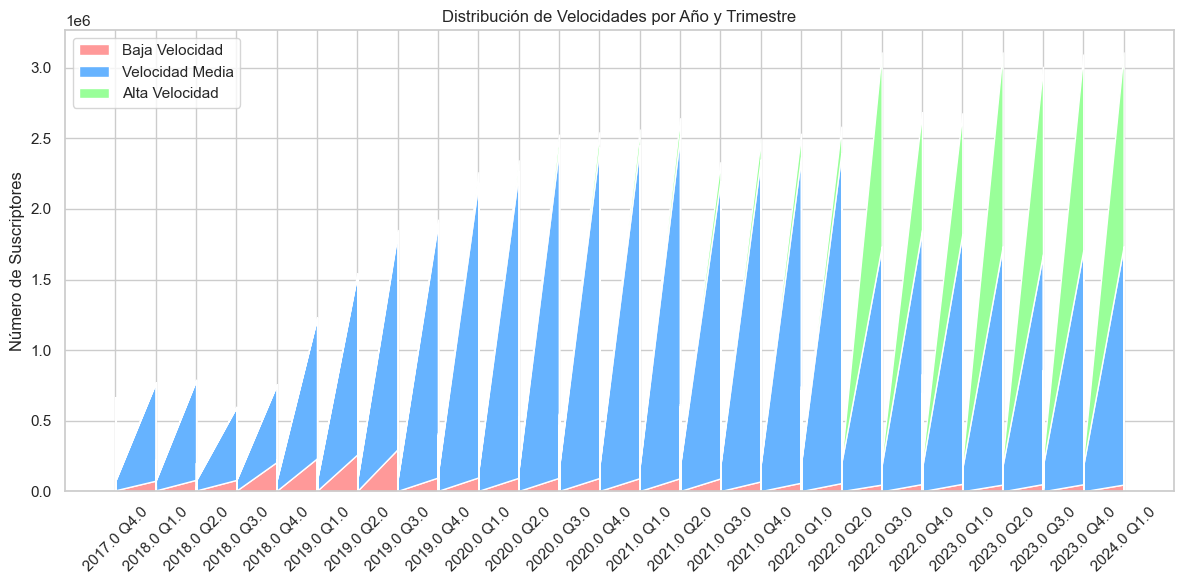

In [72]:
# Agrupamos los datos por Año y Trimestre
agrupado_por_velocidad['Año_Trimestre'] = agrupado_por_velocidad['Año'].astype(str) + ' Q' + agrupado_por_velocidad['Trimestre'].astype(str)

# Ordenamos los datos por Año y Trimestre para que las líneas sean coherentes
agrupado_por_velocidad = agrupado_por_velocidad.sort_values(by=['Año', 'Trimestre'])

# Creamos el gráfico de área apilada
plt.figure(figsize=(12, 6))
plt.stackplot(agrupado_por_velocidad['Año_Trimestre'],
              agrupado_por_velocidad['Baja Velocidad'],
              agrupado_por_velocidad['Velocidad Media'],
              agrupado_por_velocidad['Alta Velocidad'],
              labels=['Baja Velocidad', 'Velocidad Media', 'Alta Velocidad'],
              colors=['#ff9999','#66b3ff','#99ff99'])
plt.xticks(rotation=45)
plt.ylabel('Número de Suscriptores')
plt.title('Distribución de Velocidades por Año y Trimestre')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

- Inicialmente, las suscripciones están dominadas por velocidades bajas, que representan la mayoría de las áreas en la parte izquierda del gráfico (coloreado en rosa).
- A medida que avanza el tiempo, las velocidades medias (en azul) comienzan a tomar un protagonismo mayor, reemplazando gradualmente las bajas velocidades.
- Finalmente, en los últimos trimestres del gráfico (desde 2022 en adelante), se observa un crecimiento considerable de las suscripciones de alta velocidad (en verde), indicando una transición clara hacia conexiones más rápidas, lo cual es un signo positivo en términos de desarrollo tecnológico. 

 Es interesante notar un patrón cíclico, donde el número de suscriptores parece subir y bajar en cada año, con los picos más altos a final de cada año. Esto podría estar relacionado con la estacionalidad de los contratos de internet, donde los usuarios podrían estar activando o desactivando sus servicios en ciertas épocas.
  Aunque hay un crecimiento notable en las velocidades medias y altas, las velocidades bajas no desaparecen por completo. Siguen teniendo una pequeña presencia, lo que podría indicar que todavía existen áreas o sectores que mantienen conexiones de baja velocidad, posiblemente debido a limitaciones geográficas o de infraestructura

### **Importar más datos**

In [73]:
accesos_por_tecnologia = pd.read_excel(internet_file, sheet_name='Accesos Por Tecnología') # Accesos por Tecnología
Totales_acc_tecno = pd.read_excel(internet_file, sheet_name='Totales Accesos Por Tecnología')

penetracion_hogares = pd.read_excel(internet_file, sheet_name='Penetracion-hogares') # penetración por hogar
total_pen_hog = pd.read_excel(internet_file, sheet_name='Penetracion-totales')

total_acc_velocidad = pd.read_excel(internet_file, sheet_name='Totales Accesos por velocidad') # accesos por velocidad
acc_por_velocidad = pd.read_excel(internet_file, sheet_name='Accesos por velocidad')

In [116]:
accesos_por_tecnologia['año']

,Año,Trimestre,Provincia,ADSL,Cablemodem,Fibra óptica,Wireless,Otros,Total
0,2024,1,Buenos Aires,203297.0,2790663.0,1799013.0,150290.0,101294.0,5044557.0
1,2024,1,Capital Federal,70108.0,1177475.0,203756.0,4493.0,48879.0,1504711.0
2,2024,1,Catamarca,5901.0,11025.0,56542.0,1384.0,81.0,74933.0
3,2024,1,Chaco,11343.0,58929.0,64463.0,8404.0,12404.0,155543.0
4,2024,1,Chubut,26306.0,77217.0,26356.0,30867.0,9930.0,170676.0
...,...,...,...,...,...,...,...,...,...
981,2014,1,Santiago Del Estero,32567.0,3598.0,19.0,915.0,34.0,37133.0
982,2014,1,Tierra Del Fuego,21618.0,2837.0,648.0,1.0,2934.0,28038.0
983,2014,1,Tucumán,129717.0,83.0,121.0,13.0,98.0,130032.0
984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [117]:
Totales_acc_tecno

,Año,Trimestre,ADSL,Cablemodem,Fibra óptica,Wireless,Otros,Total,Periodo
0,2024,1,774475,5986957,4015101,598682,257941,11633156,Ene-Mar 2024
1,2023,4,836390,6022532,3908183,585760,194796,11547661,Oct-Dic 2023
2,2023,3,897895,6018832,3708718,581436,200027,11406908,Jul-Sept 2023
3,2023,2,1006509,5997149,3463988,581823,202428,11251897,Abr-Jun 2023
4,2023,1,1204417,6002582,3243411,576647,214838,11241895,Ene-Mar 2023
5,2022,4,1315373,6037457,3060575,572969,221740,11208114,Oct-Dic 2022
6,2022,3,1395277,6031970,2871541,557110,235230,11091128,Jul-Sept 2022
7,2022,2,1468333,5979214,2723285,556243,231609,10958684,Abr-Jun 2022
8,2022,1,1533240,6073426,2219533,545814,251996,10624009,Ene-Mar 2022
9,2021,4,1657615,5984240,2072236,523107,252596,10489794,Oct-Dic 2021


Para calcular el promedio (mean()), es necesario asegurarse de que solo las columnas numéricas se utilicen para realizar estos cálculos estadísticos como mean. Por ello primero seleccionamos las columnas numéricas antes de agrupar por provincia, para evitar problemas al calcular los promedios. 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_9724\3206280041.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=accesos_tecnologia_por_provincia, x='Provincia', y='Total', palette='viridis')


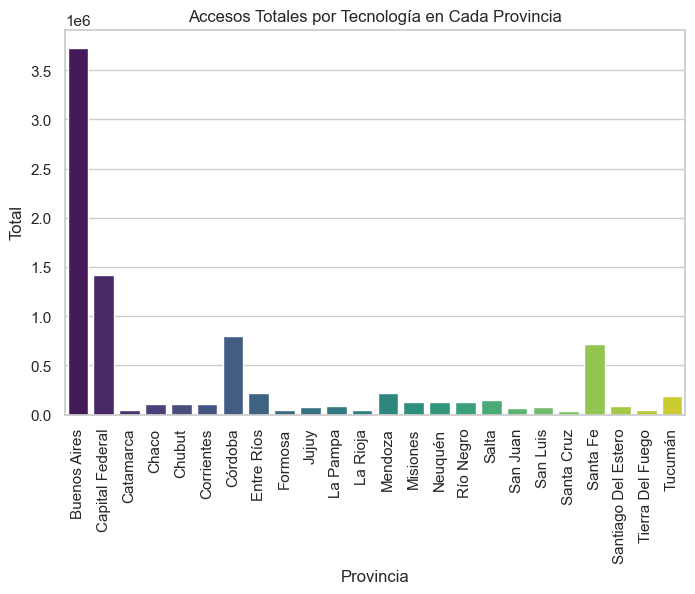

In [77]:
# Seleccionar solo las columnas numéricas antes de agrupar
accesos_tecnologia_numericas = accesos_por_tecnologia.select_dtypes(include='number')
penetracion_hogares_numericas = penetracion_hogares.select_dtypes(include='number')

# Asegurarse de que 'Provincia' siga siendo parte del DataFrame
accesos_tecnologia_numericas['Provincia'] = accesos_por_tecnologia['Provincia']
penetracion_hogares_numericas['Provincia'] = penetracion_hogares['Provincia']

# Agrupamos los datos por provincia y calculamos el promedio de los accesos por tecnología y penetración por hogares
accesos_tecnologia_por_provincia = accesos_tecnologia_numericas.groupby('Provincia').mean().reset_index()
penetracion_por_hogares = penetracion_hogares_numericas.groupby('Provincia').mean().reset_index()

# Crear gráfico de barras para los accesos por tecnología
plt.figure(figsize=(8, 5))
sns.barplot(data=accesos_tecnologia_por_provincia, x='Provincia', y='Total', palette='viridis')
plt.xticks(rotation=90)
plt.title('Accesos Totales por Tecnología en Cada Provincia')
plt.show()

In [96]:
penetracion_hogares.head(5)

,Año,Trimestre,Provincia,Accesos por cada 100 hogares
0,2024,1,Buenos Aires,81.10
1,2024,1,Capital Federal,119.53
2,2024,1,Catamarca,68.82
3,2024,1,Chaco,46.70
4,2024,1,Chubut,84.89


In [86]:
Totales_acc_tecno.head(5)

,Año,Trimestre,ADSL,Cablemodem,Fibra óptica,Wireless,Otros,Total,Periodo
0,2024,1,774475,5986957,4015101,598682,257941,11633156,Ene-Mar 2024
1,2023,4,836390,6022532,3908183,585760,194796,11547661,Oct-Dic 2023
2,2023,3,897895,6018832,3708718,581436,200027,11406908,Jul-Sept 2023
3,2023,2,1006509,5997149,3463988,581823,202428,11251897,Abr-Jun 2023
4,2023,1,1204417,6002582,3243411,576647,214838,11241895,Ene-Mar 2023


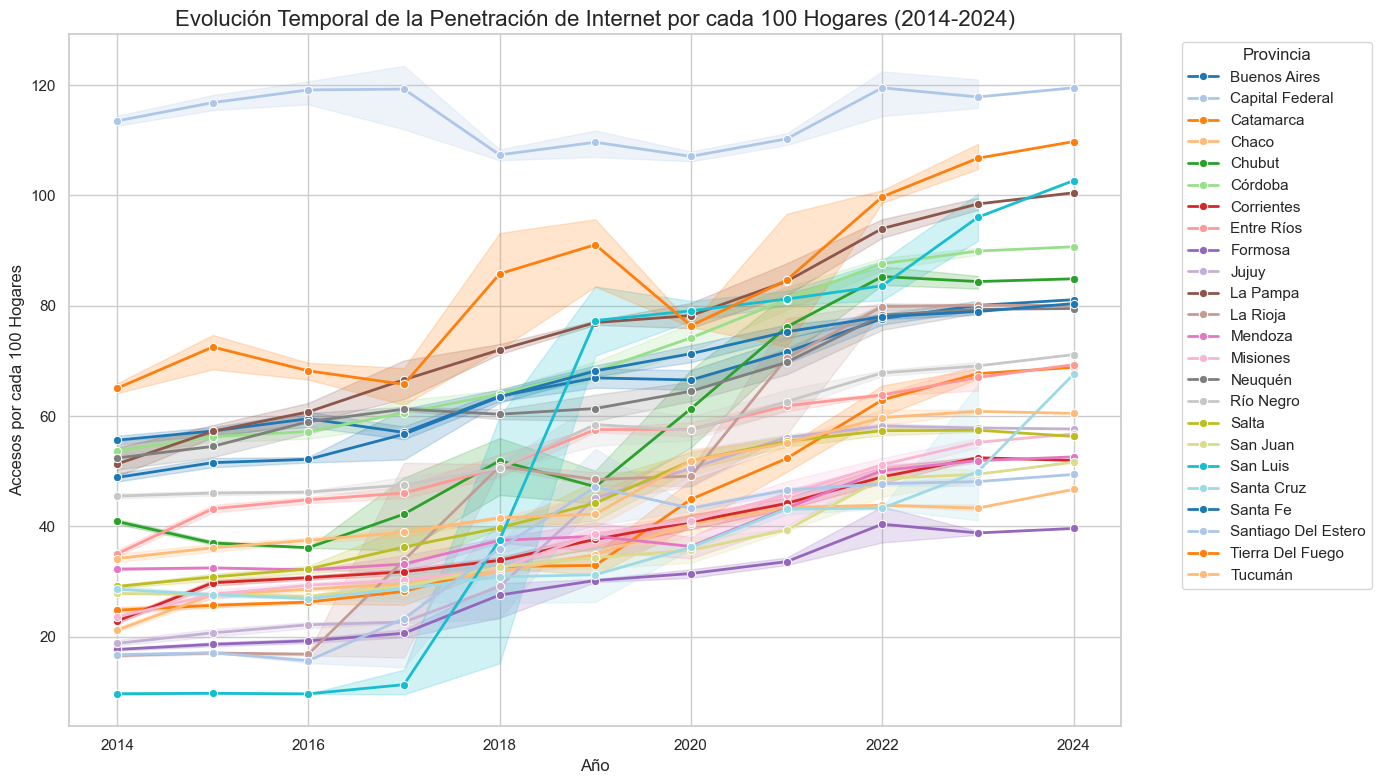

In [114]:
# Crear gráfico de líneas para mostrar la evolución temporal de la penetración de internet por cada 100 hogares
plt.figure(figsize=(14, 8))

# Generar el gráfico de líneas
sns.lineplot(x='Año', y='Accesos por cada 100 hogares', hue='Provincia', data=penetracion_hogares, marker="o", palette='tab20', linewidth=2)

# Personalizar el gráfico
plt.title('Evolución Temporal de la Penetración de Internet por cada 100 Hogares (2014-2024)', fontsize=16)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Accesos por cada 100 Hogares', fontsize=12)
plt.legend(title='Provincia', bbox_to_anchor=(1.05, 1), loc='upper left')  # Leyenda fuera del gráfico

# Mostrar el gráfico
plt.tight_layout()
plt.show()

- Incremento Generalizado de la Penetración de Internet: En la mayoría de las provincias, se observa un incremento constante en la penetración de internet a lo largo de los años. Este aumento refleja el crecimiento de la adopción de tecnologías de internet en los hogares a nivel nacional. Esto sugiere que la demanda de servicios de internet sigue creciendo, lo cual es una oportunidad para que la empresa siga invirtiendo en mejorar la infraestructura y oferta de servicios de internet.
- Diferencias entre Provincias: Hay grandes variaciones en la penetración de internet entre provincias,provincias como Capital Federal y Tierra del Fuego tienen una penetración significativamente mayor que otras como Formosa y Santiago Del Estero. Esto indica áreas donde las provincias más rezagadas, necesitan una mayor inversión en infraestructura para cerrar la brecha digital. La empresa de telecomunicaciones podría priorizar estas regiones para expansión y mejora de los servicios.
- Estancamiento o Descenso en Algunas Provincias: Aunque en la mayoría de las provincias la penetración ha aumentado, en algunas como San Luis y Río Negro, la curva muestra signos de estancamiento o menor crecimiento en los últimos años. Este comportamiento sugiere que, en estas provincias, la empresa podría investigar las causas detrás del estancamiento. Tal vez existan barreras económicas, geográficas o de infraestructura que podrían ser atendidas para reactivar el crecimiento.

In [128]:
# Verificar los datos nulos en el DataFrame
print(accesos_por_tecnologia.isnull().sum())

Año             0
Trimestre       0
Provincia       0
ADSL            0
Cablemodem      0
Fibra óptica    0
Wireless        0
Otros           0
Total           0
dtype: int64


In [129]:
# Eliminar las filas con valores nulos en cualquier columna
accesos_por_tecnologia.dropna(inplace=True) 
print(accesos_por_tecnologia.isnull().sum())

Año             0
Trimestre       0
Provincia       0
ADSL            0
Cablemodem      0
Fibra óptica    0
Wireless        0
Otros           0
Total           0
dtype: int64


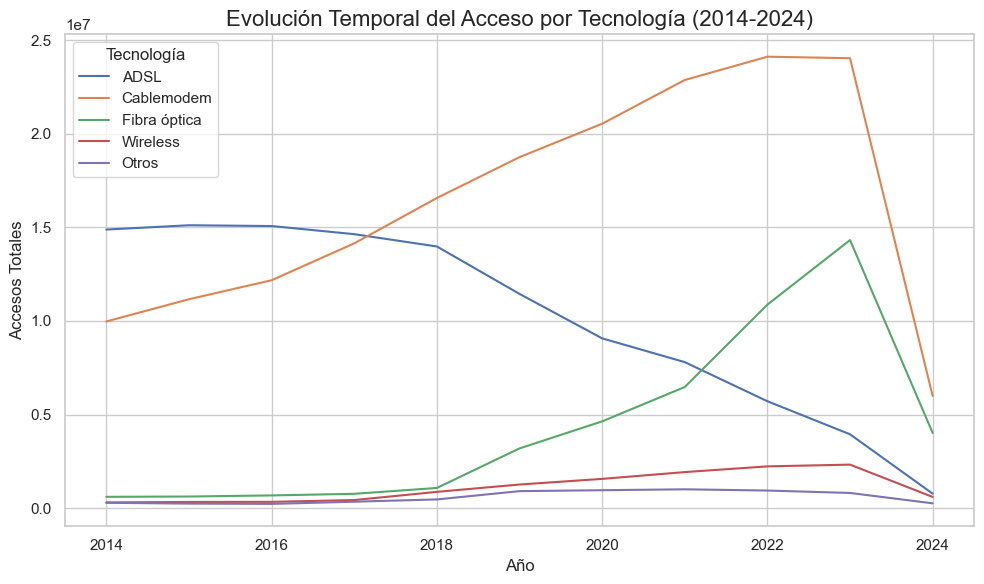

In [130]:
# Datos para el gráfico (asegúrate de tener el DataFrame 'Totales_acc_tecno' cargado)
data_tecnologia = Totales_acc_tecno.groupby(['Año']).sum().reset_index()

# Crear el gráfico de evolución temporal por tecnología
plt.figure(figsize=(10, 6))
sns.lineplot(x='Año', y='ADSL', data=data_tecnologia, label='ADSL')
sns.lineplot(x='Año', y='Cablemodem', data=data_tecnologia, label='Cablemodem')
sns.lineplot(x='Año', y='Fibra óptica', data=data_tecnologia, label='Fibra óptica')
sns.lineplot(x='Año', y='Wireless', data=data_tecnologia, label='Wireless')
sns.lineplot(x='Año', y='Otros', data=data_tecnologia, label='Otros')

plt.title('Evolución Temporal del Acceso por Tecnología (2014-2024)', fontsize=16)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Accesos Totales', fontsize=12)
plt.legend(title='Tecnología')
plt.grid(True)
plt.tight_layout()

plt.show()

- Migración tecnológica: La evolución muestra una clara migración de tecnologías más antiguas como ADSL hacia tecnologías más rápidas y modernas como la fibra óptica. Esto está impulsado por la creciente demanda de internet de alta velocidad y la mejora de la infraestructura.
- Transición en el mercado: Aunque Cablemodem sigue siendo relevante, la fibra óptica está ganando rápidamente terreno y podría reemplazarlo como la principal tecnología de acceso en los próximos años.
- Oportunidades para expansión de Fibra Óptica: Dado el incremento sustancial en la adopción de fibra óptica, hay una clara oportunidad para la expansión de esta tecnología, especialmente en áreas urbanas y periurbanas.

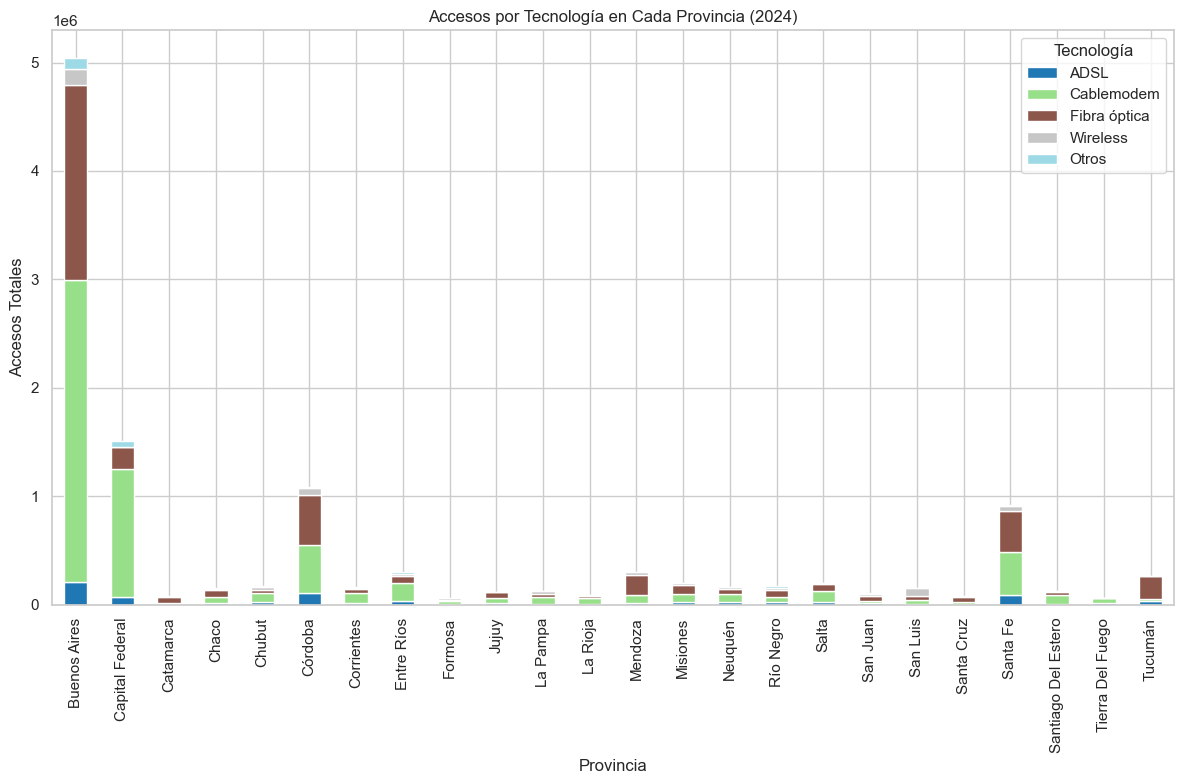

In [131]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar datos para el año 2024
accesos_2024 = accesos_por_tecnologia[accesos_por_tecnologia['Año'] == 2024]

# Crear gráfico de barras apiladas por tecnología
fig, ax = plt.subplots(figsize=(12, 8))
accesos_2024.set_index('Provincia')[['ADSL', 'Cablemodem', 'Fibra óptica', 'Wireless', 'Otros']].plot(kind='bar', stacked=True, ax=ax, cmap='tab20')

plt.title('Accesos por Tecnología en Cada Provincia (2024)')
plt.ylabel('Accesos Totales')
plt.xlabel('Provincia')
plt.xticks(rotation=90)
plt.legend(title='Tecnología')
plt.tight_layout()
plt.show()